# Interaction with the World Homework (#3)
Python Computing for Data Science (c) J Bloom, UC Berkeley, 2016

# 1) Monty: The Python Siri

Let's make a Siri-like program with the following properties:
   - record your voice command
   - use a webservice to parse that sound file into text
   - based on what the text, take three different types of actions:
       - send an email to yourself
       - do some math
       - tell a joke

So for example, if you say "Monty: email me with subject hello and body goodbye", it will email you with the appropriate subject and body. If you say "Monty: tell me a joke" then it will go to the web and find a joke and print it for you. If you say, "Monty: calculate two times three" it should response with printing the number 6.

Hint: you can use speed-to-text apps like Houndify to return the text (but not do the actions). You'll need to sign up for a free API and then follow documentation instructions for using the service within Python. 

In [1]:
import houndify as hfy
from hound_keys import HOUND_KEYS

print(HOUND_KEYS)

import json
import pyaudio
import wave
import time

import smtplib
from email.mime.text import MIMEText

{'CLIENT_ID': '2duzMCCZviuSWa2_wqeG0A==', 'CLIENT_KEY': 'wbnbxHaPbw9yiB_kztZvLy4DnsjjSB0d8L-zRQju3fD0bZ2f1s0jHpTcBDXOsBwS6lr5VfncOej1vgZ8dGvz_Q==', 'USER_ID': 'mayen'}


In [3]:
def capture_stream(**kwargs):
    chunk = kwargs.get('chunk',1024)
    FORMAT = pyaudio.paInt16
    CHANNELS = kwargs.get('CHANNELS',1)
    RATE = kwargs.get('RATE',16000)
    RECORD_SECONDS = kwargs.get('RECORD_SECONDS',5)
    WAVE_OUTPUT_FILENAME = kwargs.get('WAVE_OUTPUT_FILENAME','audio/output-sing1.wav')
    p = pyaudio.PyAudio()
    stream = p.open(format = FORMAT,
                    channels = CHANNELS,
                    rate = RATE,
                    input = True,
                    frames_per_buffer = chunk)
    all = []
    for i in range(0, int(RATE / chunk * RECORD_SECONDS)):
        data = stream.read(chunk)
        all.append(data)
    print("*** done recording ***")
    stream.close()
    p.terminate()
    
    data = b"".join(all)
    wf = wave.open(WAVE_OUTPUT_FILENAME, "wb")
    wf.setnchannels(CHANNELS)
    wf.setsampwidth(p.get_sample_size(FORMAT))
    wf.setframerate(RATE)
    wf.writeframes(data)
    wf.close()
    
    return WAVE_OUTPUT_FILENAME

def read_wav(fname):
    audio = wave.open(fname)
    BUFFER_SIZE = 512
    samples = audio.readframes(BUFFER_SIZE)
    
    if audio.getsampwidth() != 2:
        print("%s: wrong sample width (must be 16-bit)" % fname)
        return
    if audio.getframerate() != 8000 and audio.getframerate() != 16000:
        print("%s: unsupported sampling frequency (must be either 8 or 16 khz)" % fname)
        return
    if audio.getnchannels() != 1:
        print("%s: must be single channel (mono)" % fname)
        return
    return audio, samples

class StreamListener(hfy.HoundListener):
    def onPartialTranscript(self, transcript):
        pass
    def onFinalResponse(self, response):
        self.response = response
        pass
    def onError(self, err):
        print("ERROR")
    
def QueryHoundify(KEYS):
    requestinfo = {'ClientID':KEYS['CLIENT_ID'],
               'UserID': KEYS['USER_ID'],
               'Latitude': 37.872095,
               'Longitude': -122.257842}
    BUFFER_SIZE = 512
    client = hfy.StreamingHoundClient(KEYS['CLIENT_ID'],
                                      KEYS['CLIENT_KEY'],
                                      KEYS['USER_ID'],
                                      requestinfo)
    
    fname = 'audio/output-sing1.wav'
    audio, samples = read_wav(fname)
    listener = StreamListener()
    client.start(listener)
    finished = False
    while not finished:
        finished = client.fill(samples)
        time.sleep(0.01)     ## simulate real-time so we can see the partial transcripts
        samples = audio.readframes(BUFFER_SIZE)
        if len(samples) == 0:
            break
    client.finish()
    
    return listener.response

def is_email(response):
    command = response.get('CommandKind','None')
    if 'email' not in command.lower():
        return False
    return True

def email_data(hfy_response):
    response = hfy_response['AllResults'][0]
    if not is_email(response):
        return
    data = response['ClientActionSucceededResult']['ConversationState']['PropagatedData']
    body = data['Email']['Body']
    subject  = data['Email']['Subject']
    return data['Email']

def send_email(data, me='mypymail@gmail.com',password='emailforgood'):
    msg = MIMEText('')
    msg['Subject'] = data['Subject']
    msg['From'] = me
    msg['To'] = me
    
    s = smtplib.SMTP('smtp.gmail.com:587')
    s.ehlo()
    s.starttls()
    s.login(me,password)
    s.send_message(msg)
    s.quit()
    return msg

def jarvis():
    print('Recording...')
    capture_stream()
    response = QueryHoundify(HOUND_KEYS)['AllResults'][0]
    if is_email(response):
        ed = email_data(c)
        msg = send_email(ed)
        print('Email Sent')
        return
    else:
        print(response['WrittenResponse'])
        return

In [4]:
jarvis()

Recording...
*** done recording ***
A sandwich walked into a bar. The bartender told him, "I'm sorry, but you'll have to leave. We don't serve food here."


# 2) Write a program that identifies musical notes from sound (AIFF) files. 

  - Run it on the supplied sound files (12) and report your program’s results. 
  - Use the labeled sounds (4) to make sure it works correctly. The provided sound files contain 1-3 simultaneous notes from different organs.
  - Save copies of any example plots to illustrate how your program works.
  
  https://piazza.com/berkeley/fall2016/ay250/resources -> hw3_sound_files.zip

Hints: You’ll want to decompose the sound into a frequency power spectrum. Use a Fast Fourier Transform. Be care about “unpacking” the string hexcode into python data structures. The sound files use 32 bit data. Play around with what happens when you convert the string data to other integer sizes, or signed vs unsigned integers. Also, beware of harmonics.

In [163]:
import numpy as np
import pandas as pd
import soundfile as sf
import glob

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [212]:
A4 = 440
C0 = A4*pow(2, -4.75)
name = np.array(["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B"])
    
def pitch(freq):
    h = 12*np.log2(freq/C0)
    octave = h/12
    n = (h%12).astype(int)
    n[0] = 0
    return name[n]

class Notes(object):
    
    def __init__(self,fname):
        self.fname = fname
        self.data, self.rate = sf.read(fname)
        self.data = np.mean(self.data,axis=1)
                
        self.spec = np.fft.rfft(self.data)
        self.power = np.abs(self.spec)**2
        self.freq = np.fft.fftfreq(self.spec.size,1/self.rate)
        self.time = np.arange(self.data.size)/self.rate
        
        self.dom_freq = self.freq[np.argsort(self.power)[:10]]
        self.dom_pow = np.sort(self.power)[:10]
        
    def plot_spec(self):
        plt.figure(figsize=(8,6))
        plt.plot(self.freq,self.power)
        plt.show()
        
    def plot_amp(self):
        plt.figure(figsize=(8,6))
        plt.plot(self.time,self.data)
        plt.show()
        
    def plot_notes(self):
        plt.figure(figsize=(8,6))
        df = pd.DataFrame({'freq':notes.freq,'power':notes.power,'notes':pitch(np.abs(notes.freq))})
        music = df.groupby(['notes'],as_index=False).sum()[['notes','power']]
        plt.title(self.fname)
        sns.barplot(x='notes',y='power',data=music, errwidth=0)
        plt.show()

In [213]:
notes = Notes('sound_files/A4_PopOrgan.aif')

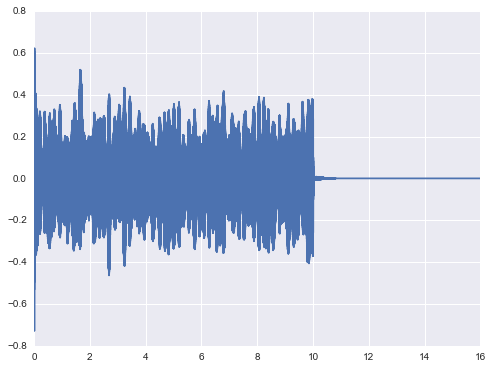

In [214]:
notes.plot_amp()

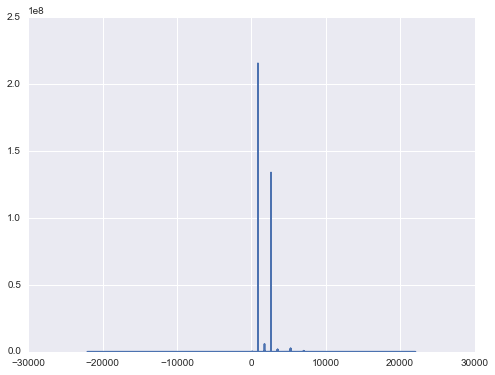

In [215]:
notes.plot_spec()

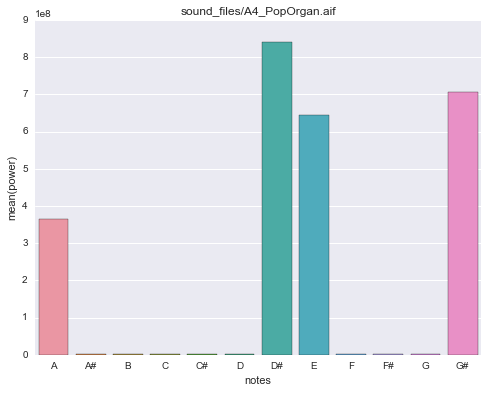

In [216]:
notes.plot_notes()

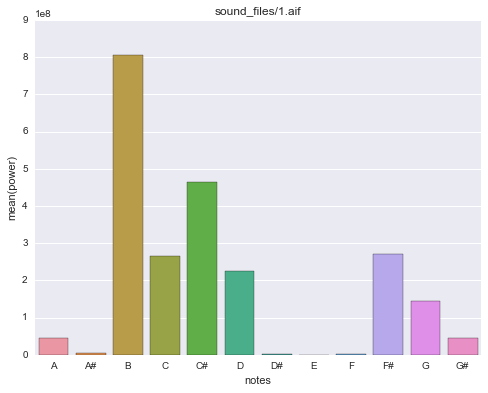

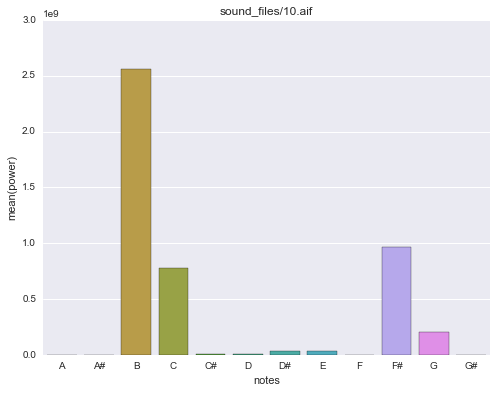

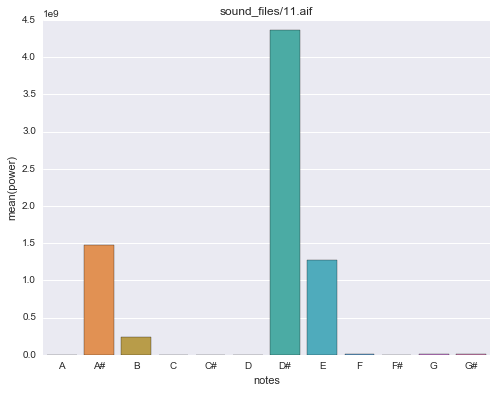

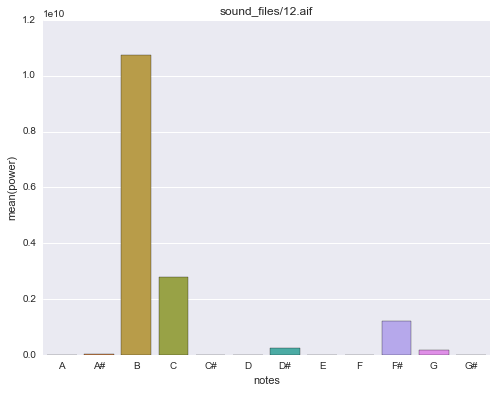

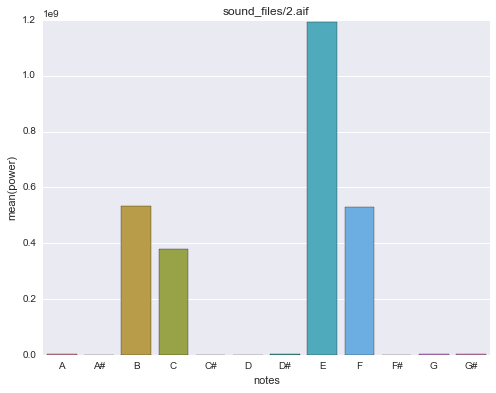

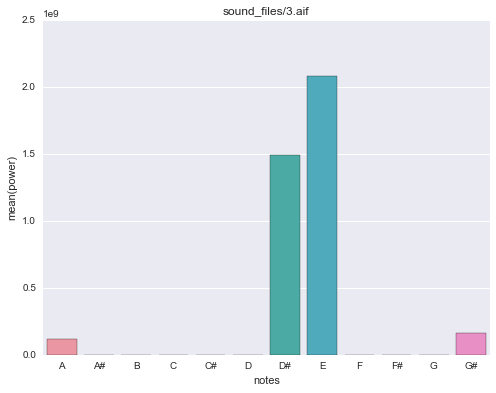

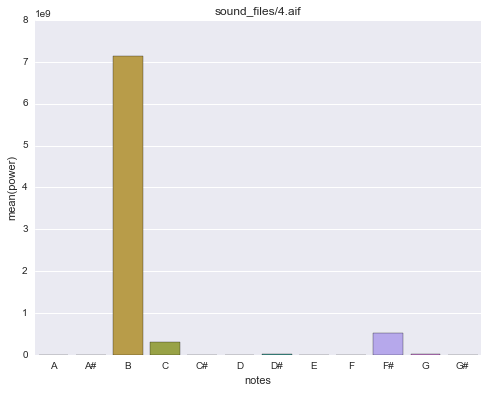

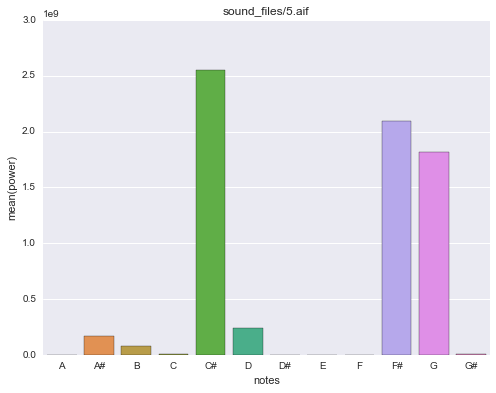

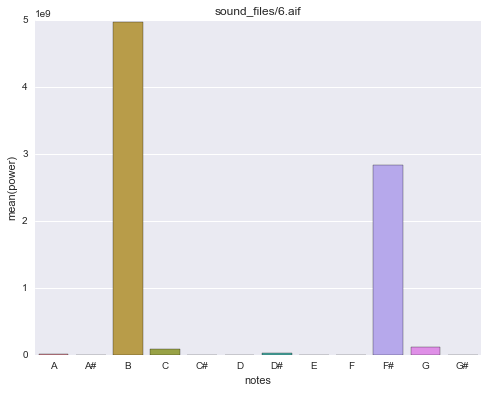

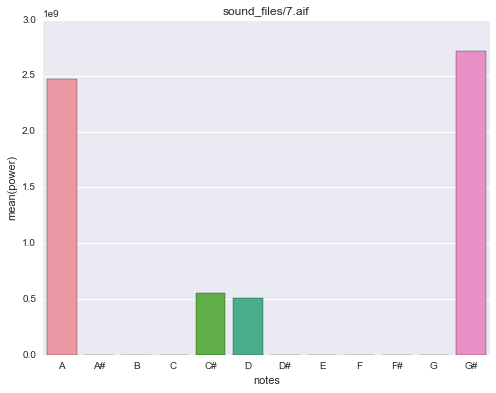

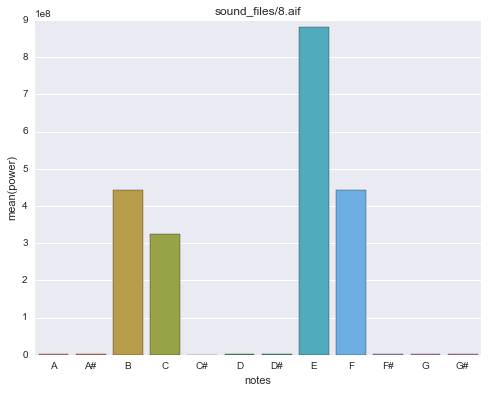

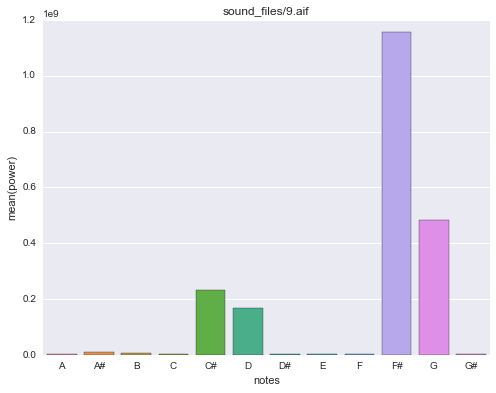

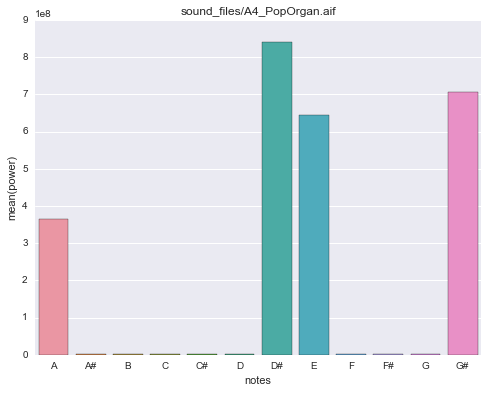

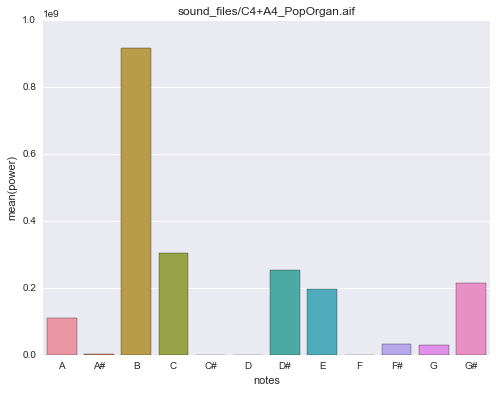

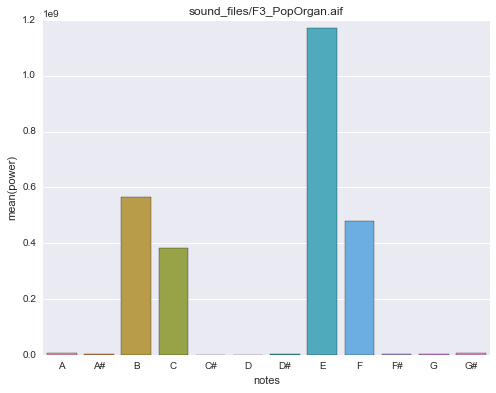

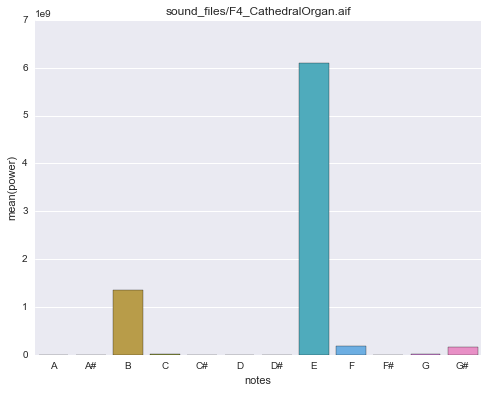

In [217]:
sounds = glob.glob('sound_files/*.aif')
for sound in sounds:
    notes = Notes(sound)
    notes.plot_notes()